Importing libraries and gathering urls

In [1]:
import pandas as pd
import requests
from io import StringIO

# 1. Dataset URLs from OWID
urls = {
    'undernourishment': "https://ourworldindata.org/grapher/prevalence-of-undernourishment.csv",
    'calorie_supply': "https://ourworldindata.org/grapher/daily-per-capita-caloric-supply.csv",
    'agri_employment': "https://ourworldindata.org/grapher/share-of-the-labor-force-employed-in-agriculture.csv",
    'stunting_rate': "https://ourworldindata.org/grapher/share-of-children-younger-than-5-who-suffer-from-stunting.csv",
    'severe_food_insecurity': "https://ourworldindata.org/grapher/global-hunger-index-vs-gdp-per-capita.csv?v=1&csvType=full&useColumnShortNames=true",
    'global_hunger_index': "https://ourworldindata.org/grapher/global-hunger-index.csv",
    'children_wasted': "https://ourworldindata.org/grapher/share-of-children-with-a-weight-too-low-for-their-height-wasting.csv",
    'food_loss_index': "https://ourworldindata.org/grapher/global-food-loss-index.csv",
    'price_of_healthy': "https://ourworldindata.org/grapher/cost-foods-healthy-diet.csv",
    'population': "https://ourworldindata.org/grapher/population.csv",
    'gdp_per_capita': "https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv"
}

Scraping and storing datasets

In [2]:
dataframes = {}
for name, url in urls.items():
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        dataframes[name] = pd.read_csv(StringIO(resp.text))
        print(f"Successfully loaded '{name}'")
    except Exception as e:
        print(f"Error loading '{name}': {e}")

Successfully loaded 'undernourishment'
Successfully loaded 'calorie_supply'
Successfully loaded 'agri_employment'
Successfully loaded 'stunting_rate'
Successfully loaded 'severe_food_insecurity'
Successfully loaded 'global_hunger_index'
Successfully loaded 'children_wasted'
Successfully loaded 'food_loss_index'
Successfully loaded 'price_of_healthy'
Successfully loaded 'population'
Successfully loaded 'gdp_per_capita'


Renaming columns to make them easier to read

In [3]:
dataframes['undernourishment'] = dataframes['undernourishment'].rename(columns={'2.1.1 Prevalence of undernourishment | 000000000024000 || Value | 006121 || percent': 'undernourishment_rate(%)'})
dataframes['stunting_rate'] = dataframes['stunting_rate'].rename(columns={'Stunting prevalence among children under 5 years of age (% height-for-age <-2 SD), model-based estimates - Sex: both sexes': 'stunting_rate(%)'})
dataframes['global_hunger_index'] = dataframes['global_hunger_index'].rename(columns={'Global Hunger Index (2021)': 'global_hunger_index'})
dataframes['children_wasted'] = dataframes['children_wasted'].rename(columns={'Prevalence of wasting, weight for height (% of children under 5)': 'children_wasted_rate(%)'})
dataframes['food_loss_index'] = dataframes['food_loss_index'].rename(columns={'12.3.1 - Global food loss index - AG_FLS_INDEX': 'food_loss_index'})
dataframes['price_of_healthy'] = dataframes['price_of_healthy'].rename(columns={
    'Cost of starchy staples': 'starchy_staples_cost($)',
    'Cost of legumes, nuts and seeds': 'legumes_nuts_seeds_cost($)',
    'Cost of oils and fats': 'oils_fats_cost($)',
    'Cost of fruits': 'fruits_cost($)',
    'Cost of vegetables': 'vegetables_cost($)',
    'Cost of animal-source foods': 'animal_source_foods_cost($)'
})
dataframes['population'] = dataframes['population'].rename(columns={'Population (historical)': 'population'})
dataframes['gdp_per_capita'] = dataframes['gdp_per_capita'].rename(columns={'GDP per capita, PPP (constant 2021 international $)': 'gdp_per_capita($)'})
dataframes['calorie_supply'] = dataframes['calorie_supply'].rename(columns={'Daily calorie supply per person': 'calorie_supply_per_person(kcal/person/day)'})
dataframes['agri_employment'] = dataframes['agri_employment'].rename(columns={'share_employed_agri': 'agri_employment_share(%)'})

Merging the dataframe

In [4]:
# Starting with the first dataframe and merge all others onto it
df = list(dataframes.values())[0]

for name, df_to_merge in list(dataframes.items())[1:]:
    # Ensure all dataframes have the same 'Entity', 'Code', and 'Year' columns
    common_cols = ['Entity', 'Code', 'Year']
    # If a dataframe lacks 'Code', merge only on 'Entity' and 'Year'
    if 'Code' not in df_to_merge.columns:
        common_cols.remove('Code')

    df = pd.merge(df, df_to_merge, on=common_cols, how='outer')
    print(f"Merged '{name}'. Current shape: {df.shape}")

Merged 'calorie_supply'. Current shape: (13391, 5)
Merged 'agri_employment'. Current shape: (15296, 6)
Merged 'stunting_rate'. Current shape: (16910, 7)
Merged 'severe_food_insecurity'. Current shape: (64026, 12)
Merged 'global_hunger_index'. Current shape: (64026, 14)
Merged 'children_wasted'. Current shape: (64026, 15)
Merged 'food_loss_index'. Current shape: (64053, 16)
Merged 'price_of_healthy'. Current shape: (64058, 22)
Merged 'population'. Current shape: (64058, 23)
Merged 'gdp_per_capita'. Current shape: (64058, 25)


Filtering recent data

In [5]:
#Filter for years 2000 and above
df_final = df[df['Year'] >= 2000]
#Final cleaning and renaming
df_final = df_final.rename(columns={'Entity': 'country', 'Year': 'year', 'Code': 'code'})
df_final.shape

(9368, 25)

In [6]:
# --- FIX FOR CELL 16: Ensure core columns are NOT dropped ---

# Identify columns with a high percentage of null values
null_counts = df_final.isnull().sum()
total_rows = len(df_final)
null_percentages = (null_counts / total_rows) * 100

# Define a threshold for considering a column "mostly null" (e.g., > 50% null)
null_threshold = 50

# Get the list of columns to drop based on the threshold
columns_to_drop_threshold = null_percentages[null_percentages > null_threshold].index.tolist()

# Define core analytical columns that MUST be preserved, even if they have many nulls
core_columns_to_keep = [
    'undernourishment_rate(%)',
    'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)',
    'stunting_rate(%)',
    'population',
    'gdp_per_capita($)'
]

# Add specific columns identified as generally unnecessary for the final merged analysis
specific_columns_to_drop = [
    'population_historical',
    'severe_food_insecurity_rate',
    'children_wasted_rate',
    'food_loss_index',
    'starchy_staples_cost',
    'legumes_nuts_seeds_cost',
    'oils_fats_cost',
    'fruits_cost',
    'vegetables_cost',
    'animal_source_foods_cost',
    'World regions according to OWID',
    'gdp_per_capita_x',
    'ny_gdp_pcap_pp_kd', # Added this as it's a GDP-related column that appears to be redundant
    'global_hunger_index',
    'starchy_staples_cost($)', # Include the renamed dollar columns here as well
    'legumes_nuts_seeds_cost($)',
    'oils_fats_cost($)',
    'fruits_cost($)',
    'vegetables_cost($)',
    'animal_source_foods_cost($)',
    'Global Hunger Index (2021)',
    '411773-annotations_x',
    '411773-annotations_y',
    'owid_region'
]

# Combine all columns flagged for dropping
columns_to_drop = list(set(columns_to_drop_threshold + specific_columns_to_drop))

# STEP: Crucial Correction - Remove core columns from the drop list
columns_to_drop = [
    col for col in columns_to_drop
    if col not in core_columns_to_keep
]

# Final list of existing columns to drop
columns_to_drop_existing = [
    col for col in columns_to_drop
    if col in df_final.columns
]

# Drop the identified columns
df_final = df_final.drop(columns=columns_to_drop_existing)

print("Columns dropped (verified existing):")
print(columns_to_drop_existing)
print("\nUpdated DataFrame shape:", df_final.shape)

# You can add this line to confirm all intended core columns are now present:
print("\nColumns remaining in df_final:")
print(df_final.columns.tolist())

Columns dropped (verified existing):
['411773-annotations_x', 'children_wasted_rate(%)', 'fruits_cost($)', 'population_historical', 'starchy_staples_cost($)', 'global_hunger_index', 'vegetables_cost($)', 'ny_gdp_pcap_pp_kd', 'owid_region', 'legumes_nuts_seeds_cost($)', 'food_loss_index', 'World regions according to OWID', 'animal_source_foods_cost($)', '411773-annotations_y', 'Global Hunger Index (2021)', 'oils_fats_cost($)']

Updated DataFrame shape: (9368, 9)

Columns remaining in df_final:
['country', 'code', 'year', 'undernourishment_rate(%)', 'calorie_supply_per_person(kcal/person/day)', 'agri_employment_share(%)', 'stunting_rate(%)', 'population', 'gdp_per_capita($)']


In [7]:
print(df_final.columns.tolist())

['country', 'code', 'year', 'undernourishment_rate(%)', 'calorie_supply_per_person(kcal/person/day)', 'agri_employment_share(%)', 'stunting_rate(%)', 'population', 'gdp_per_capita($)']


In [8]:
df_final['year'] = df_final['year'].astype(int)

Preprocessing the Values

In [9]:
#Replacing Null values with median
columns_to_impute_median = [
    'undernourishment_rate(%)',
    'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)',
    'stunting_rate(%)'
]

# Loop through each column and perform median imputation
for column in columns_to_impute_median:
    median_value = df_final[column].median()
    df_final[column] = df_final[column].fillna(median_value)
    print(f"Filled missing values in '{column}' with its median.")


Filled missing values in 'undernourishment_rate(%)' with its median.
Filled missing values in 'calorie_supply_per_person(kcal/person/day)' with its median.
Filled missing values in 'agri_employment_share(%)' with its median.
Filled missing values in 'stunting_rate(%)' with its median.


In [10]:
#Replacing null values with mean
# Impute 'population' with the mean
mean_population = df_final['population'].mean()
df_final['population'] = df_final['population'].fillna(mean_population)
print(f"Filled missing values in 'population' with its mean.")

Filled missing values in 'population' with its mean.


KNN Imputer for null values in gdp per capita

In [11]:
from sklearn.impute import KNNImputer

# Select only numerical columns needed for KNN Imputer
numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the numeric data
df_final[numeric_cols] = imputer.fit_transform(df_final[numeric_cols])

# Check if nulls in gdp_per_capita are filled
print(df_final['gdp_per_capita($)'].isnull().sum())


0


In [12]:
# --- NEW CELL: Standardize Country Names in df_final (FIX for KeyError) ---

import numpy as np

# List of target country names to be used in the plotting cell
target_countries = [
    'Afghanistan',
    'Ethiopia',
    'India',
    'Brazil',
    'United States',
    'Norway'
]

# 1. Clean the 'country' column for trailing/leading spaces (most common fix)
df_final['country'] = df_final['country'].str.strip()

# 2. Define a dictionary of common name mismatches to unify them
# Add any variations you think might exist in your merged OWID data here
country_name_mapping = {
    # Common OWID/Wikipedia variations:
    'United States of America': 'United States',
    'USA': 'United States',
    'Brazil, Federative Republic of': 'Brazil',
    'Brazil (Total)': 'Brazil',
    # Ensure any other possible variations of your target list are handled
}

# 3. Apply the mapping to the 'country' column
df_final['country'] = df_final['country'].replace(country_name_mapping)

# 4. Final check: Identify which of your target countries might still be missing
missing_countries = [
    c for c in target_countries
    if c not in df_final['country'].unique()
]

if missing_countries:
    print(f"⚠️ **Warning:** The following countries are still missing from df_final after cleaning: {missing_countries}")
    print("Please inspect df_final['country'].unique() to find the exact name and add it to the mapping.")
else:
    print("✅ Country names standardized successfully. Plotting should now work.")

✅ Country names standardized successfully. Plotting should now work.


In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9368 entries, 237 to 64057
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     9368 non-null   object 
 1   code                                        6042 non-null   object 
 2   year                                        9368 non-null   float64
 3   undernourishment_rate(%)                    9368 non-null   float64
 4   calorie_supply_per_person(kcal/person/day)  9368 non-null   float64
 5   agri_employment_share(%)                    9368 non-null   float64
 6   stunting_rate(%)                            9368 non-null   float64
 7   population                                  9368 non-null   float64
 8   gdp_per_capita($)                           9368 non-null   float64
dtypes: float64(7), object(2)
memory usage: 731.9+ KB


SCRAPING GHI USING BEAUTIFUL SOUP

In [14]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Wikipedia GHI page
url = "https://en.wikipedia.org/wiki/Global_Hunger_Index"

def get_ghi_data_robust(url):
    try:
        # Set a custom header to mimic a real browser
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                          "AppleWebKit/537.36 (KHTML, like Gecko) "
                          "Chrome/118.0 Safari/537.36"
        }

        # Fetch the page content
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        # Parse the HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract all tables from the parsed HTML
        all_tables = pd.read_html(str(soup))

        # Find the table containing 'Country' and '2023'
        best_table = None
        for table in all_tables:
            if 'Country' in table.columns and '2023' in table.columns:
                best_table = table
                break

        if best_table is None:
            print("Could not locate the GHI table. Check Wikipedia structure.")
            return None

        df = best_table.copy()
        df.columns = df.columns.astype(str).str.strip().str.replace(u'\xa0', u'')
        df.replace(['–', '—', '-', '', ' '], np.nan, inplace=True)

        return df

    except Exception as e:
        print(f"Error while fetching data: {e}")
        return None

# Run the scraper
df_ghi_wiki = get_ghi_data_robust(url)

if df_ghi_wiki is not None:
    print("GHI data successfully scraped!\n")
    print(df_ghi_wiki.head())
    print("\nColumns:", df_ghi_wiki.columns.tolist())
else:
    print(" Scraping failed. df_ghi_wiki is None.")


GHI data successfully scraped!

  Rank in 2023 Rank in 2015                 Country  2000 2008 2015 2023  \
0      1-20[a]         1-15                 Belarus    <5   <5   <5   <5   
1      1-20[a]           19  Bosnia and Herzegovina   9.4  6.5  5.3   <5   
2      1-20[a]         1-15                   Chile    <5   <5   <5   <5   
3      1-20[a]         1-15       China (more info)  13.4  7.1   <5   <5   
4      1-20[a]         1-15                 Croatia    <5   <5   <5   <5   

  Absolute change since 2015 Percent change since 2015 Unnamed: 9  
0                        NaN                       NaN        NaN  
1                        NaN                       NaN        NaN  
2                        NaN                       NaN        NaN  
3                        NaN                       NaN        NaN  
4                        NaN                       NaN        NaN  

Columns: ['Rank in 2023', 'Rank in 2015', 'Country', '2000', '2008', '2015', '2023', 'Absolute change 

/tmp/ipython-input-2904769485.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  all_tables = pd.read_html(str(soup))


In [15]:
df_ghi_wiki.shape

(132, 10)

In [16]:
# Check if df_ghi_wiki exists and is a DataFrame
if df_ghi_wiki is not None and isinstance(df_ghi_wiki, pd.DataFrame):
    df_ghi_wiki.columns = df_ghi_wiki.columns.str.strip().str.replace(u'\xa0', u'')

    columns_to_drop = ['Rank in 2023', 'Rank in 2015', 'Absolute changesince 2015', 'Percent changesince 2015']

    df_ghi_wiki_cleaned = df_ghi_wiki.drop(columns=columns_to_drop, errors='ignore')

    null_percentages = (df_ghi_wiki_cleaned.isnull().sum() / len(df_ghi_wiki_cleaned)) * 100
    columns_to_drop_threshold = null_percentages[null_percentages > 50].index.tolist()
    df_ghi_wiki_cleaned = df_ghi_wiki_cleaned.drop(columns=columns_to_drop_threshold, errors='ignore')


    print("Columns dropped. Cleaned DataFrame head:")
    print(df_ghi_wiki_cleaned.head())
else:
    print("df_ghi_wiki is not available to clean.")
df_ghi_wiki_cleaned.shape

Columns dropped. Cleaned DataFrame head:
                  Country  2000 2008 2015 2023 Absolute change since 2015  \
0                 Belarus    <5   <5   <5   <5                        NaN   
1  Bosnia and Herzegovina   9.4  6.5  5.3   <5                        NaN   
2                   Chile    <5   <5   <5   <5                        NaN   
3       China (more info)  13.4  7.1   <5   <5                        NaN   
4                 Croatia    <5   <5   <5   <5                        NaN   

  Percent change since 2015  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  


(132, 7)

CLEANING IT FOR PLOTTING

**THE PLOTS**

In [17]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for choropleth
import plotly.express as px

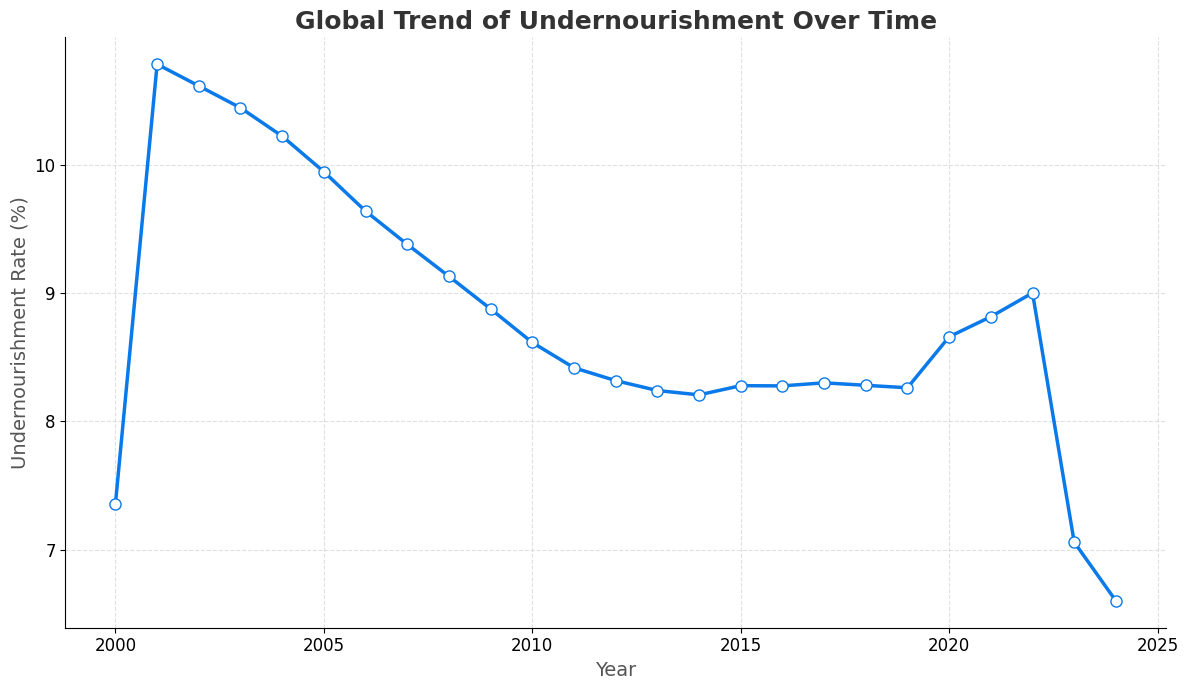

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean of key indicators per year
global_trend = df_final.groupby('year')['undernourishment_rate(%)'].mean()

plt.figure(figsize=(12, 7))
plt.plot(global_trend.index, global_trend.values,
         marker='o', linestyle='-', color='#0A79E9', # A distinct color
         linewidth=2.5, markersize=8, markerfacecolor='white', markeredgecolor='#0A79E9')
plt.title("Global Trend of Undernourishment Over Time", fontsize=18, fontweight='bold', color='#333333')
plt.xlabel("Year", fontsize=14, color='#555555')
plt.ylabel("Undernourishment Rate (%)", fontsize=14, color='#555555')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

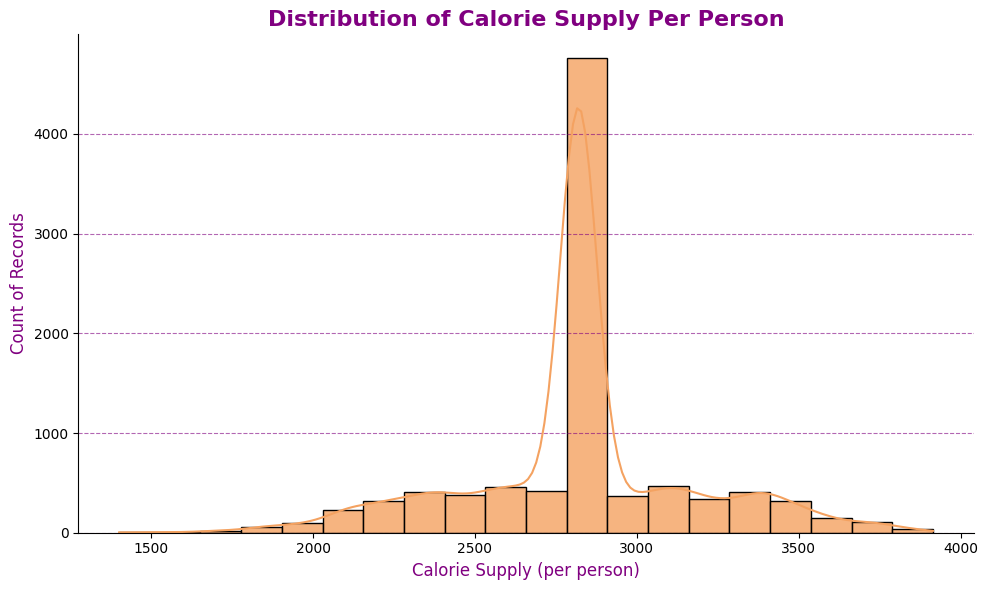

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_final['calorie_supply_per_person(kcal/person/day)'], bins=20, kde=True,
             color='#F4A261', edgecolor='black', linewidth=1, alpha=0.8)
plt.title('Distribution of Calorie Supply Per Person', fontsize=16, fontweight='bold', color='purple')
plt.xlabel('Calorie Supply (per person)', fontsize=12, color='purple')
plt.ylabel('Count of Records', fontsize=12, color='purple')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6, color='purple')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2316246527.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='year', y='calorie_supply_per_person(kcal/person/day)', data=df_final,


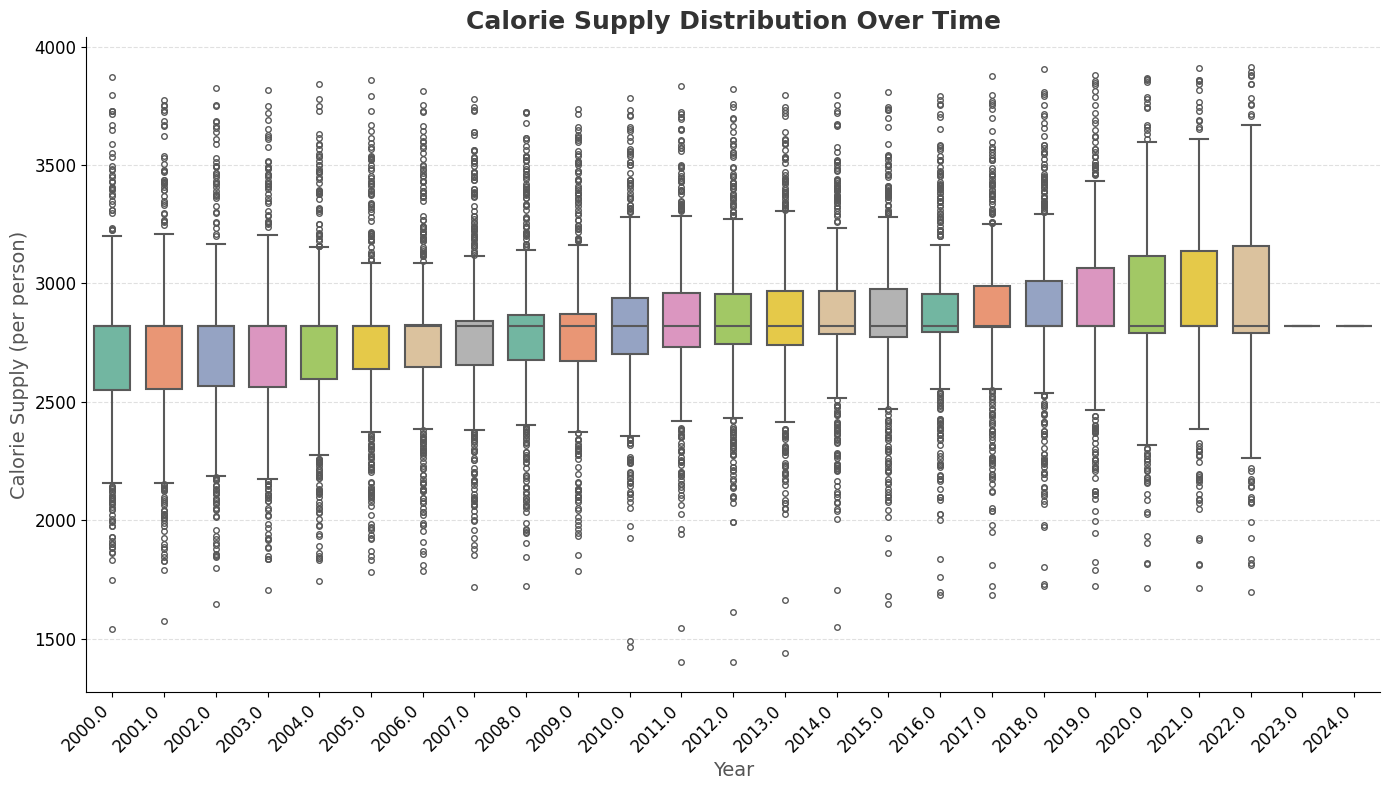

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.boxplot(x='year', y='calorie_supply_per_person(kcal/person/day)', data=df_final,
            palette='Set2', width=0.7, linewidth=1.5, fliersize=4) # Fliers are outliers
plt.title('Calorie Supply Distribution Over Time', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Year', fontsize=14, color='#555555')
plt.ylabel('Calorie Supply (per person)', fontsize=14, color='#555555')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

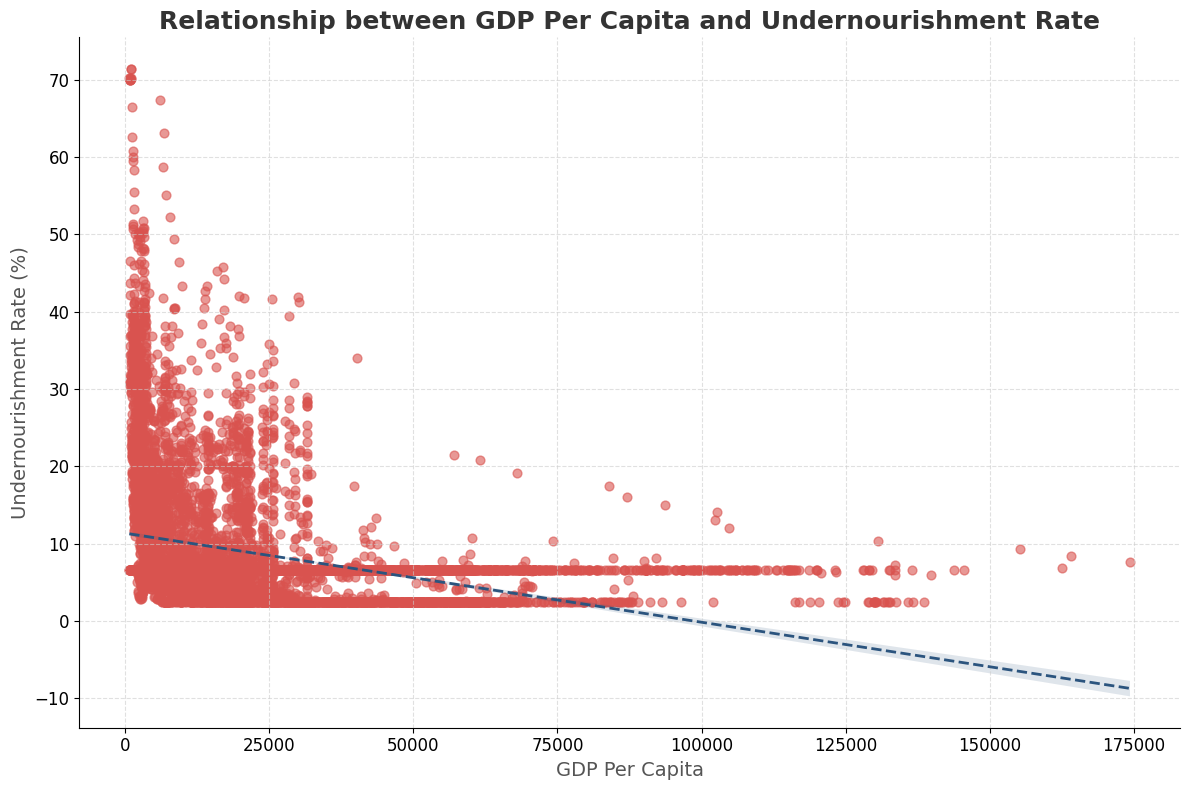

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.regplot(x='gdp_per_capita($)', y='undernourishment_rate(%)', data=df_final,
            scatter_kws={'alpha':0.6, 's': 40, 'color': '#D9534F'}, # Customize scatter points
            line_kws={'color':'#2B547E', 'linestyle': '--', 'linewidth': 2}) # Add a regression line
plt.title('Relationship between GDP Per Capita and Undernourishment Rate', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('GDP Per Capita', fontsize=14, color='#555555')
plt.ylabel('Undernourishment Rate (%)', fontsize=14, color='#555555')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

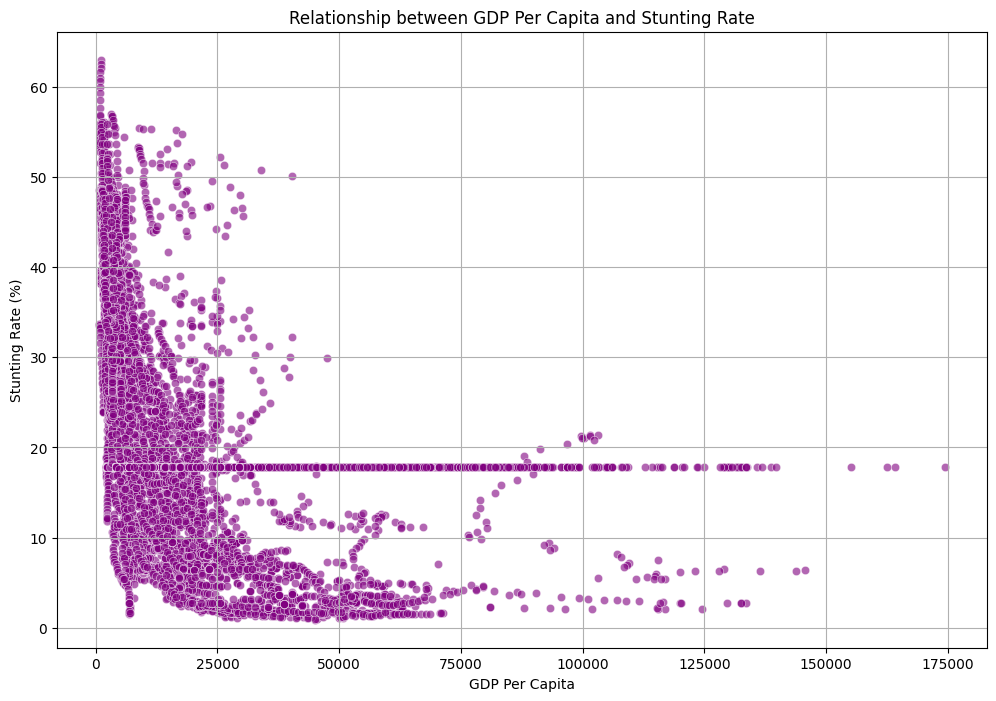

In [22]:
# Plot 5: Scatter plot for GDP vs. Stunting Rate
plt.figure(figsize=(12, 8))
sns.scatterplot(x='gdp_per_capita($)', y='stunting_rate(%)', data=df_final, alpha=0.6, color='purple')
plt.title('Relationship between GDP Per Capita and Stunting Rate')
plt.xlabel('GDP Per Capita')
plt.ylabel('Stunting Rate (%)')
plt.grid(True)
plt.show()

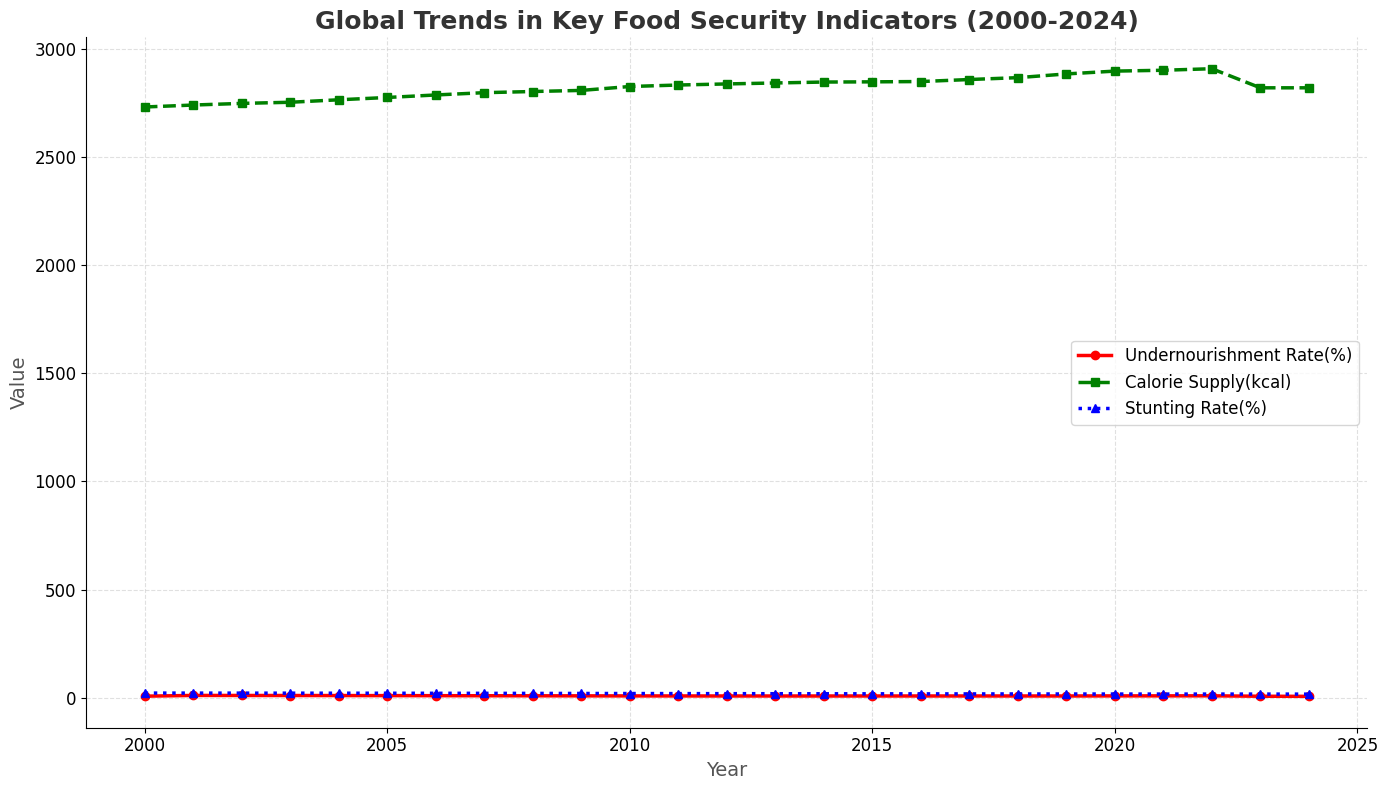

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

global_trends = df_final.groupby('year')[['undernourishment_rate(%)', 'calorie_supply_per_person(kcal/person/day)', 'stunting_rate(%)']].mean()

plt.figure(figsize=(14, 8))
plt.plot(global_trends.index, global_trends['undernourishment_rate(%)'],
         marker='o', linestyle='-', color='red', linewidth=2.5, label='Undernourishment Rate(%)')
plt.plot(global_trends.index, global_trends['calorie_supply_per_person(kcal/person/day)'],
         marker='s', linestyle='--', color='green', linewidth=2.5, label='Calorie Supply(kcal)')
plt.plot(global_trends.index, global_trends['stunting_rate(%)'],
         marker='^', linestyle=':', color='blue', linewidth=2.5, label='Stunting Rate(%)')

plt.title('Global Trends in Key Food Security Indicators (2000-2024)', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Year', fontsize=14, color='#555555')
plt.ylabel('Value', fontsize=14, color='#555555')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

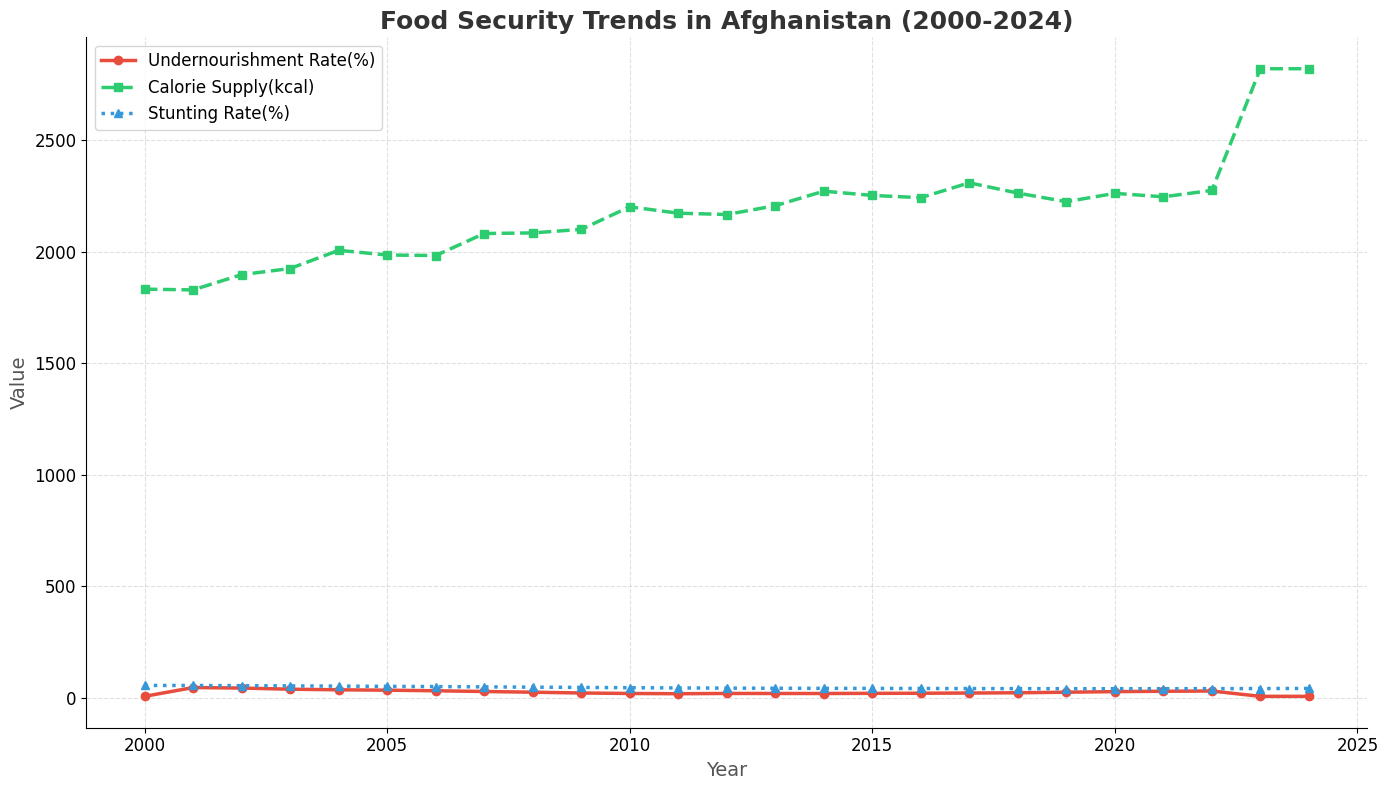

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

afghanistan_data = df_final[df_final['country'] == 'Afghanistan'].sort_values('year')

plt.figure(figsize=(14, 8), facecolor='white')
plt.plot(afghanistan_data['year'], afghanistan_data['undernourishment_rate(%)'],
         marker='o', linestyle='-', color='#E74C3C', linewidth=2.5, label='Undernourishment Rate(%)')
plt.plot(afghanistan_data['year'], afghanistan_data['calorie_supply_per_person(kcal/person/day)'],
         marker='s', linestyle='--', color='#2ECC71', linewidth=2.5, label='Calorie Supply(kcal)')
plt.plot(afghanistan_data['year'], afghanistan_data['stunting_rate(%)'],
         marker='^', linestyle=':', color='#3498DB', linewidth=2.5, label='Stunting Rate(%)')

plt.title('Food Security Trends in Afghanistan (2000-2024)', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Year', fontsize=14, color='#555555')
plt.ylabel('Value', fontsize=14, color='#555555')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [25]:
# Plot 8: Choropleth Map of Undernourishment Rate for the Latest Year
# Find the latest year for each country
df_latest_year = df_final.sort_values('year', ascending=False).drop_duplicates('country')

# Create the choropleth map
fig = px.choropleth(df_latest_year,
                    locations="code",
                    color="undernourishment_rate(%)",
                    hover_name="country",
                    animation_frame="year",
                    color_continuous_scale=px.colors.sequential.YlOrRd,
                    title='Global Undernourishment Rate (Most Recent Year)')

fig.show()

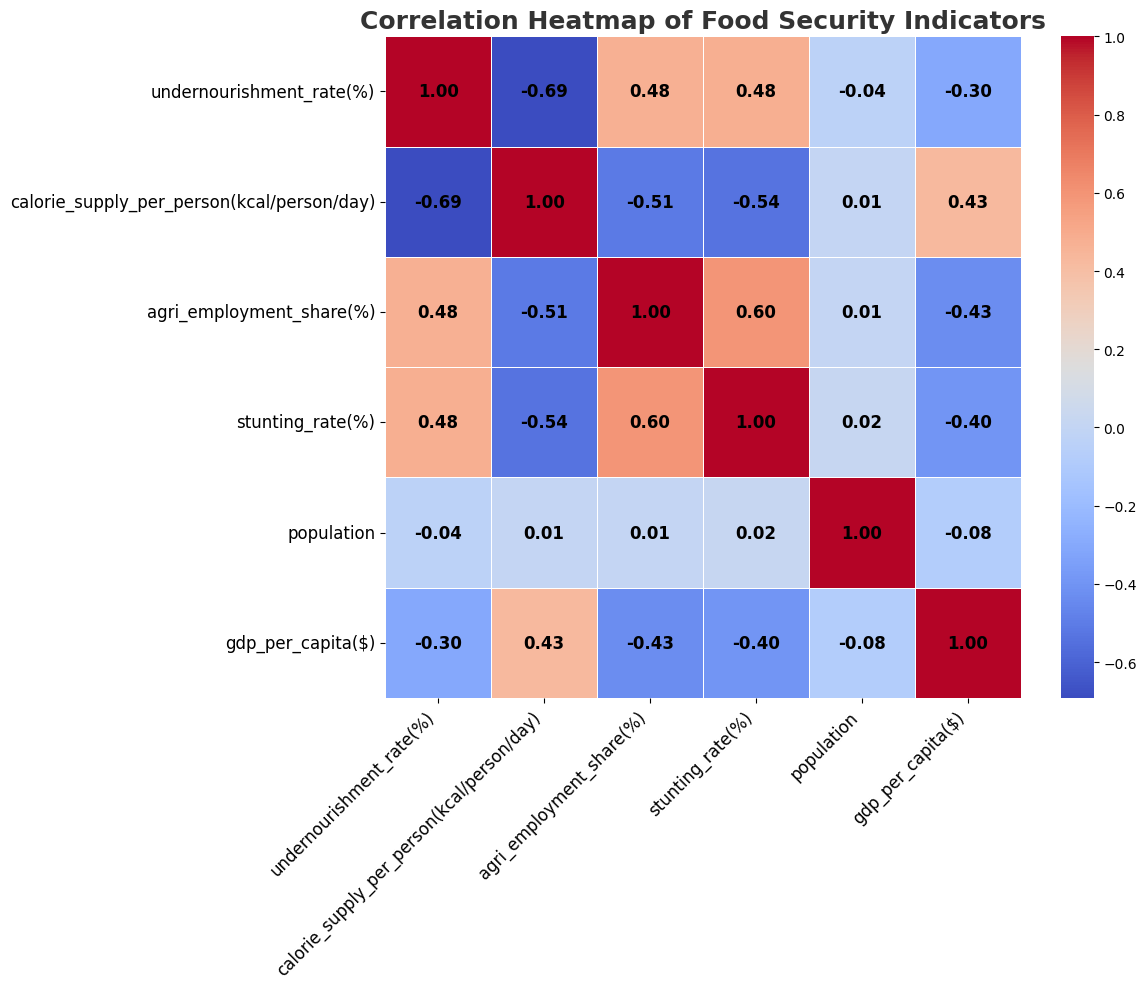

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the numerical columns for the correlation matrix
numerical_cols = [
    'undernourishment_rate(%)',
    'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)',
    'stunting_rate(%)',
    'population',
    'gdp_per_capita($)'
]
df_numeric = df_final[numerical_cols]

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, annot_kws={"size": 12, "weight": "bold", "color": "black"})
plt.title('Correlation Heatmap of Food Security Indicators', fontsize=18, fontweight='bold', color='#333333')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

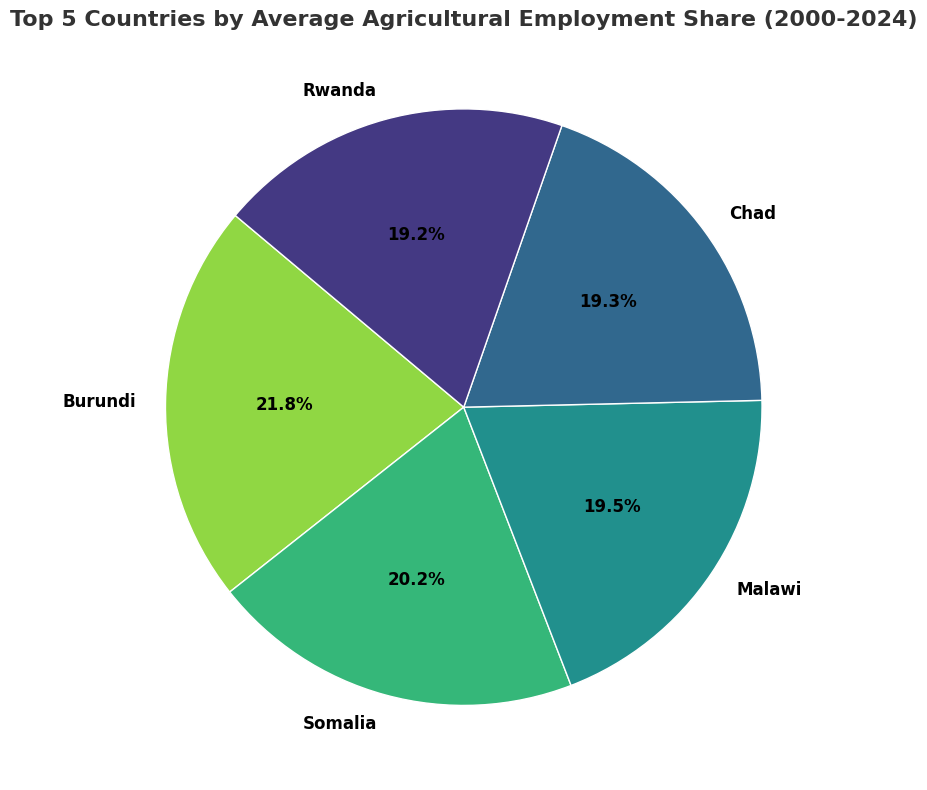

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

top_agri_employment = df_final.groupby('country')['agri_employment_share(%)'].mean().nlargest(5)

plt.figure(figsize=(10, 8))
plt.pie(top_agri_employment, labels=top_agri_employment.index,
        autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis_r", len(top_agri_employment)),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Top 5 Countries by Average Agricultural Employment Share (2000-2024)', fontsize=16, fontweight='bold', color='#333333')
plt.ylabel('')
plt.tight_layout()
plt.show()

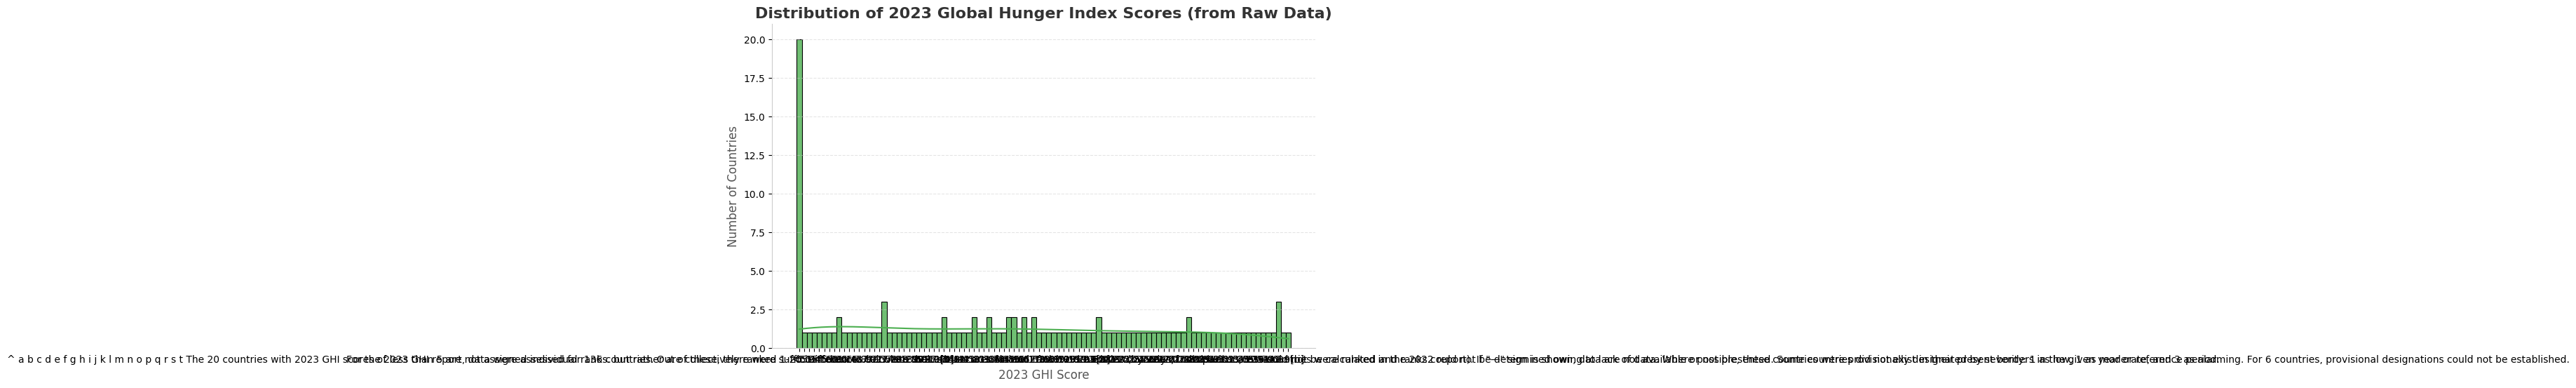

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

if df_ghi_wiki is not None:
    df_plot_data = df_ghi_wiki.copy()
    df_plot_data.replace(['–', '—', '-', '', ' '], float('nan'), inplace=True) # Added ' ' to replace empty strings

    # 2. Rename the column for clarity (assuming '2023' is the target column)
    # Check if '2023' column exists after cleaning column names
    if '2023' in df_plot_data.columns:
         df_plot_data.rename(columns={'2023': 'global_hunger_index_2023'}, inplace=True)
    else:
        print(" '2023' column not found in the GHI data. Cannot plot.")
        df_plot_data = pd.DataFrame()

    year_columns = ['2000', '2008', '2015', '2023'] # Adjust this list if you have other year columns
    for col in year_columns:
        # Check if the year column exists before attempting to convert
        if col in df_plot_data.columns:
            df_plot_data[col] = pd.to_numeric(df_plot_data[col], errors='coerce')

    # 4. Drop rows with NaN GHI scores for plotting
    if 'global_hunger_index_2023' in df_plot_data.columns:
        df_plot_data.dropna(subset=['global_hunger_index_2023'], inplace=True)
    if not df_plot_data.empty:
        plt.figure(figsize=(10, 6))

        sns.histplot(
            df_plot_data['global_hunger_index_2023'],
            bins=15,
            kde=True,
            color='#4CAF50', # A pleasant green color
            edgecolor='black', # Add black edges to bars
            linewidth=0.8,
            alpha=0.8
        )

        plt.title('Distribution of 2023 Global Hunger Index Scores (from Raw Data)', fontsize=16, fontweight='bold', color='#333333')
        plt.xlabel('2023 GHI Score', fontsize=12, color='#555555')
        plt.ylabel('Number of Countries', fontsize=12, color='#555555')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.5, color='#cccccc') # Lighter grid

        # Add a border around the plot area
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_edgecolor('#cccccc')
        plt.gca().spines['bottom'].set_edgecolor('#cccccc')

        plt.tight_layout()
        plt.show()
    else:
        print(" `df_ghi_wiki` has no valid numeric GHI scores after minimal cleaning for plotting. Cannot plot histogram.")
else:
    print(" `df_ghi_wiki` is None. The web scraping in the previous cell may have failed.")

/tmp/ipython-input-3778625978.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




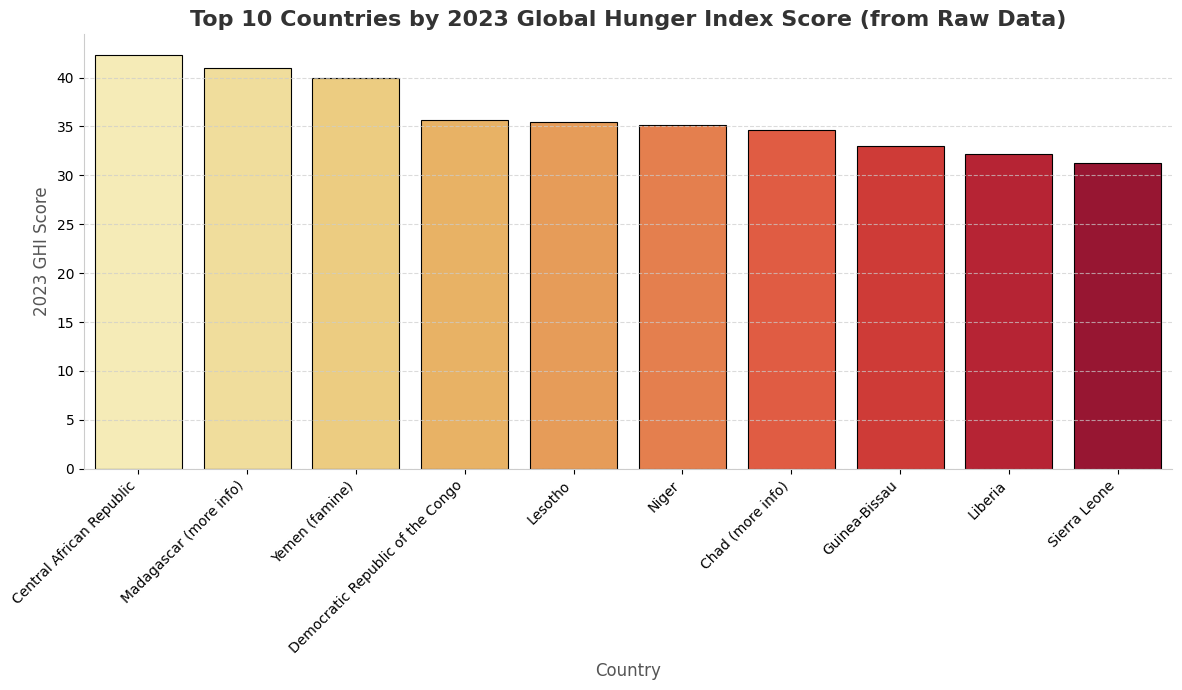

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

if df_ghi_wiki is not None:
    df_plot_data = df_ghi_wiki.copy()

    rename_mapping = {}
    if 'Country' in df_plot_data.columns:
        rename_mapping['Country'] = 'country'
    if '2023' in df_plot_data.columns:
        rename_mapping['2023'] = 'global_hunger_index_2023'

    if rename_mapping:
        df_plot_data.rename(columns=rename_mapping, inplace=True)
    else:
        print(" Required columns ('Country' or '2023') not found in the GHI data. Cannot plot.")
        df_plot_data = pd.DataFrame() # Create an empty DataFrame to prevent further errors

    if not df_plot_data.empty and 'global_hunger_index_2023' in df_plot_data.columns:
        # Convert GHI score to numeric, coercing errors to NaN
        df_plot_data['global_hunger_index_2023'] = pd.to_numeric(df_plot_data['global_hunger_index_2023'], errors='coerce')

        # Extract country name by removing (ISO) part
        df_plot_data['country'] = df_plot_data['country'].apply(
            lambda x: re.sub(r'\s*\([A-Z]{3}\)', '', str(x)).strip()
        )

        df_plot_data.dropna(subset=['global_hunger_index_2023'], inplace=True)

        if not df_plot_data.empty:
            # Sort and select the top 10 countries by GHI score
            df_top_10_ghi = df_plot_data.sort_values(by='global_hunger_index_2023', ascending=False).head(10)

            plt.figure(figsize=(12, 7))

            sns.barplot(
                x='country',
                y='global_hunger_index_2023',
                data=df_top_10_ghi,
                palette='YlOrRd', # A nice sequential palette
                edgecolor='black', # Add black edges to bars
                linewidth=0.8
            )

            plt.title('Top 10 Countries by 2023 Global Hunger Index Score (from Raw Data)', fontsize=16, fontweight='bold', color='#333333')
            plt.xlabel('Country', fontsize=12, color='#555555')
            plt.ylabel('2023 GHI Score', fontsize=12, color='#555555')
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7, color='#cccccc') # Lighter grid

            # Add a border around the plot area
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['left'].set_edgecolor('#cccccc')
            plt.gca().spines['bottom'].set_edgecolor('#cccccc')

            plt.tight_layout()
            plt.show()
        else:
            print(" `df_ghi_wiki` has no valid numeric GHI scores.")
    else:
        print(" `df_ghi_wiki` has no valid numeric GHI scores after minimal cleaning for plotting. Cannot plot histogram.")

else:
    print(" `df_ghi_wiki` is None. The web scraping in the previous cell may have failed.")

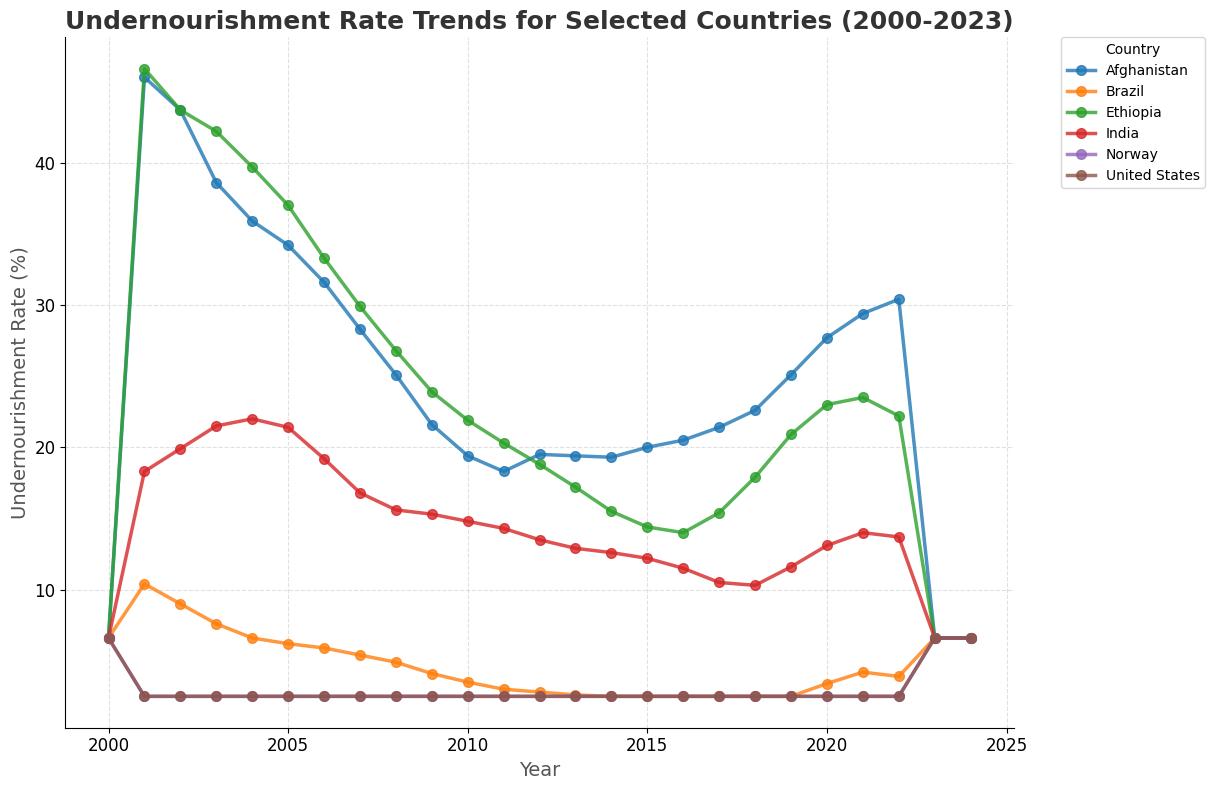

In [30]:
selected_countries_for_undernourishment = [
    'Afghanistan',
    'Ethiopia',
    'India',
    'Brazil',
    'United States',
    'Norway'
]
df_undernourishment_trends = df_final[
    df_final['country'].isin(selected_countries_for_undernourishment)
].pivot_table(
    index='year',
    columns='country',
    values='undernourishment_rate(%)',
    aggfunc='mean' # Use mean in case of multiple entries per year/country
).dropna() # Drop years where any selected country has missing data
if not df_undernourishment_trends.empty:
    plt.figure(figsize=(14, 8))
    for country in df_undernourishment_trends.columns:
        plt.plot(df_undernourishment_trends.index, df_undernourishment_trends[country],
                 marker='o', linestyle='-', linewidth=2.5, markersize=7, alpha=0.8,
                 label=country)
    plt.title('Undernourishment Rate Trends for Selected Countries (2000-2023)',
              fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Year', fontsize=14, color='#555555')
    plt.ylabel('Undernourishment Rate (%)', fontsize=14, color='#555555')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6, color='#CCCCCC')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for legend
    plt.show()
else:
    print(" No data available .")

In [31]:
df_final.columns

Index(['country', 'code', 'year', 'undernourishment_rate(%)',
       'calorie_supply_per_person(kcal/person/day)',
       'agri_employment_share(%)', 'stunting_rate(%)', 'population',
       'gdp_per_capita($)'],
      dtype='object')

In [32]:
if df_ghi_wiki is not None:
    df_ghi_wiki.to_csv('ghi_wiki.csv', index=False)
    print("df_ghi_wiki saved to ghi_wiki.csv")
else:
    print("df_ghi_wiki is None and cannot be saved.")

df_ghi_wiki saved to ghi_wiki.csv


In [33]:
df_final.to_csv('final2.csv')

#**MACHINE LEARNING IMPLEMENTATION**

In [34]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define Features (X - Predictors) and Target (Y - What we predict)
# We are predicting the UNDERNOURISHMENT RATE based on socioeconomic and food factors.
features = [
    'gdp_per_capita($)',
    'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)',
    'stunting_rate(%)'
]
target = 'undernourishment_rate(%)'
# Create the final dataset for ML, dropping any remaining NAs specific to these columns
# (Even after imputation, a small number of rows might have been missed)
ml_df = df_final[[target] + features].dropna()

X = ml_df[features]
Y = ml_df[target]
print(f"Total instances available for ML model: {len(X)}")

Total instances available for ML model: 9368


splitting and scaling data

In [35]:
# Assuming X and Y are now defined with 9,391 rows

# 1. Split the data into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# 2. Initialize and fit the StandardScaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# 3. Apply the scaling transformation to the test data
# (NOTE: We only transform, we do not fit again, to avoid data leakage)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled.")
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Data successfully split and scaled.
Training set size: 7494 samples
Testing set size: 1874 samples


In [36]:
# 1. Initialize the Random Forest Regressor
# n_estimators=100: Uses 100 individual decision trees to make the prediction.
# random_state=42: Ensures the model is reproducible.
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model using the scaled training data
print("Starting model training...")
model.fit(X_train_scaled, Y_train)
print("Model training complete.")

Starting model training...
Model training complete.



--- Model Evaluation Results ---
Mean Squared Error (MSE): 14.32
Root Mean Squared Error (RMSE): 3.78 percentage points
R-squared (R2 Score): 0.7592

--- Key Model Insight: Feature Importance ---
calorie_supply_per_person(kcal/person/day)    0.725349
gdp_per_capita($)                             0.127481
agri_employment_share(%)                      0.077641
stunting_rate(%)                              0.069529
dtype: float64


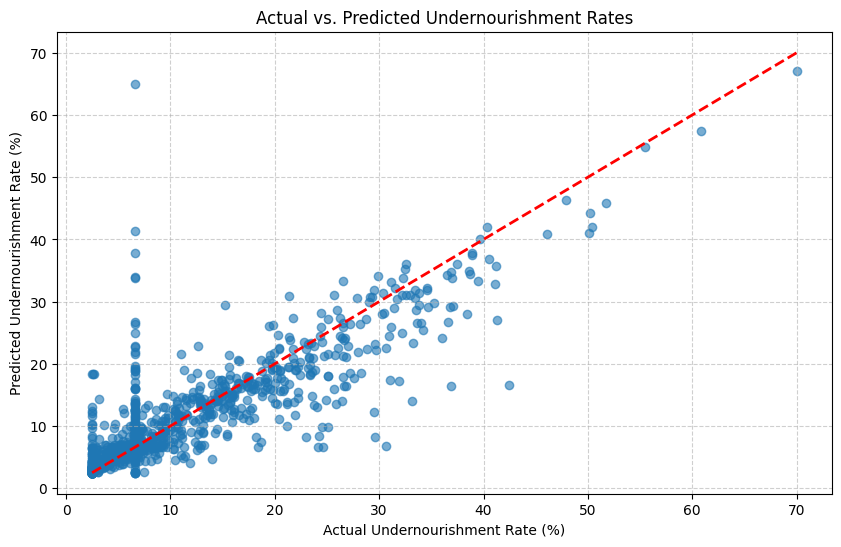

In [37]:
# Assuming 'model', 'X_test_scaled', and 'Y_test' are available from previous cells.

# 1. Make predictions on the test set
Y_pred = model.predict(X_test_scaled)

# 2. Calculate performance metrics
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} percentage points")
print(f"R-squared (R2 Score): {r2:.4f}")

# 3. Analyze Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

print("\n--- Key Model Insight: Feature Importance ---")
print(feature_importances)

# 4. Optional: Visualize Actual vs. Predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6)
# Plot the ideal 'y=x' line (where prediction equals actual)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Undernourishment Rate (%)")
plt.ylabel("Predicted Undernourishment Rate (%)")
plt.title("Actual vs. Predicted Undernourishment Rates")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [38]:
# Run this code to see all columns in your final DataFrame
print(df_final.columns)

Index(['country', 'code', 'year', 'undernourishment_rate(%)',
       'calorie_supply_per_person(kcal/person/day)',
       'agri_employment_share(%)', 'stunting_rate(%)', 'population',
       'gdp_per_capita($)'],
      dtype='object')


In [39]:
# Assuming 'model' is trained, 'scaler' is fit, and 'df_final' is available.

# 1. Define the correct column names and features
COUNTRY_COL_NAME = 'country'
YEAR_COL_NAME = 'year'
target_countries = ['Afghanistan', 'Ethiopia', 'India', 'Brazil', 'United States', 'Norway']
features = [
    'gdp_per_capita($)',
    'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)',
    'stunting_rate(%)'
]

# 2. Filter the original data using the correct column name ('country')
# .copy() is added to avoid a SettingWithCopyWarning
df_targets = df_final[df_final[COUNTRY_COL_NAME].isin(target_countries)].copy()

# 3. Get the LATEST available data point for each target country
# Sort by year (descending) and drop duplicates, keeping the latest ('first')
latest_data = df_targets.sort_values(by=YEAR_COL_NAME, ascending=False).drop_duplicates(subset=[COUNTRY_COL_NAME], keep='first')

# 4. Handle any potential remaining NaNs in the final prediction features (though KNN should have handled them)
latest_data = latest_data.dropna(subset=features + [COUNTRY_COL_NAME, YEAR_COL_NAME])

# Extract necessary components for prediction
X_predict = latest_data[features]
country_names = latest_data[COUNTRY_COL_NAME].values
latest_years = latest_data[YEAR_COL_NAME].values.astype(int) # Convert year back to integer for clean display

print("--- Data Used for 2025 Prediction (Latest Available Features) ---")
# Display the input features the model will use
print(latest_data[[COUNTRY_COL_NAME, YEAR_COL_NAME] + features].to_string(index=False))

# 5. Scale the input data using the SAME scaler trained in Cell 2
X_predict_scaled = scaler.transform(X_predict)

# 6. Make the prediction
predictions = model.predict(X_predict_scaled)

# 7. Compile the final results
df_predictions = pd.DataFrame({
    'Country': country_names,
    'Latest_Data_Year': latest_years,
    'Predicted_Undernourishment_Rate_2025(%)': predictions.round(2)
})

print("\n--- Predicted Undernourishment Rates (2025 Projection) ---")
print(df_predictions.to_string(index=False))

--- Data Used for 2025 Prediction (Latest Available Features) ---
      country   year  gdp_per_capita($)  calorie_supply_per_person(kcal/person/day)  agri_employment_share(%)  stunting_rate(%)
United States 2024.0        75491.61000                                   2819.2056                     24.57               4.2
       Norway 2024.0        91108.23400                                   2819.2056                     24.57              17.8
        India 2024.0         9817.07100                                   2819.2056                     24.57              32.9
     Ethiopia 2024.0         2884.26460                                   2819.2056                     24.57              35.5
       Brazil 2024.0        19647.91000                                   2819.2056                     24.57               8.9
  Afghanistan 2024.0         4219.98976                                   2819.2056                     24.57              42.0

--- Predicted Undernourishment Rates 

BINARY CLASSIFICATION

(CAN BE REMOVVED)

In [43]:
# Assuming model_class and scaler are available from previous cells.

# 1. Define the correct column names and features
COUNTRY_COL_NAME = 'country'
YEAR_COL_NAME = 'year'
features = [
    'gdp_per_capita($)', 'calorie_supply_per_person(kcal/person/day)',
    'agri_employment_share(%)', 'stunting_rate(%)'
]
target_countries = ['Afghanistan', 'Ethiopia', 'India', 'Brazil', 'United States', 'Norway']

# 2. Prepare data: Filter for required columns and handle potential NAs
df_report = df_final[[COUNTRY_COL_NAME, YEAR_COL_NAME, 'undernourishment_rate(%)'] + features].copy()
df_report = df_report.dropna(subset=features) # Ensure only rows used in ML are kept

# 3. Scale features for prediction
X_full_report = df_report[features]
X_full_scaled = scaler.transform(X_full_report)

# 4. Predict the risk category (0 or 1) for every record
df_report['Predicted_Risk_Category'] = model_class.predict(X_full_scaled)

# 5. Map the category to a clear label (for easy reading)
risk_map = {0: 'Low Risk (<= 15%)', 1: 'High Risk (> 15%)'}
df_report['Risk_Label'] = df_report['Predicted_Risk_Category'].map(risk_map)


print("--- CLASSIFICATION PREDICTIONS FOR TARGET COUNTRIES (LATEST YEAR) ---")

# Filter for target countries and show only the latest record for each
df_sample_results = df_report[df_report[COUNTRY_COL_NAME].isin(target_countries)]
df_latest_predictions = df_sample_results.sort_values(by=YEAR_COL_NAME, ascending=False).drop_duplicates(subset=[COUNTRY_COL_NAME], keep='first')

# Display the final, labeled results
print(df_latest_predictions[['country', 'year', 'undernourishment_rate(%)', 'Risk_Label']].to_string(index=False))

--- CLASSIFICATION PREDICTIONS FOR TARGET COUNTRIES (LATEST YEAR) ---
      country   year  undernourishment_rate(%)        Risk_Label
United States 2024.0                       6.6 Low Risk (<= 15%)
       Norway 2024.0                       6.6 Low Risk (<= 15%)
        India 2024.0                       6.6 Low Risk (<= 15%)
     Ethiopia 2024.0                       6.6 Low Risk (<= 15%)
       Brazil 2024.0                       6.6 Low Risk (<= 15%)
  Afghanistan 2024.0                       6.6 Low Risk (<= 15%)


In [44]:
# Assuming model_class and df_report are available from the previous step.

# 1. Filter for ALL records that were classified as High Risk (1)
df_high_risk = df_report[df_report['Predicted_Risk_Category'] == 1].copy()

# 2. Get the latest record for each country that has ever been High Risk
df_high_risk_latest = df_high_risk.sort_values(by='year', ascending=False).drop_duplicates(subset=['country'], keep='first')

# 3. Sort by the actual hunger rate to see the worst cases first
df_high_risk_latest = df_high_risk_latest.sort_values(by='undernourishment_rate(%)', ascending=False)

print("--- TOP 10 COUNTRIES CLASSIFIED AS HIGH RISK (> 15% Undernourishment) ---")

# Display the top 10 results
print(df_high_risk_latest[[
    'country',
    'year',
    'undernourishment_rate(%)',
    'Risk_Label'
]].head(10).to_string(index=False))

print("\n--- Summary of High Risk Classification ---")
print(f"Total number of unique countries ever classified as High Risk: {len(df_high_risk_latest)}")

--- TOP 10 COUNTRIES CLASSIFIED AS HIGH RISK (> 15% Undernourishment) ---
                     country   year  undernourishment_rate(%)        Risk_Label
                     Somalia 2022.0                      51.3 High Risk (> 15%)
                       Haiti 2022.0                      50.4 High Risk (> 15%)
                 North Korea 2018.0                      45.3 High Risk (> 15%)
                  Madagascar 2022.0                      39.7 High Risk (> 15%)
                       Yemen 2022.0                      39.5 High Risk (> 15%)
                     Liberia 2022.0                      38.4 High Risk (> 15%)
                    Zimbabwe 2022.0                      38.1 High Risk (> 15%)
Democratic Republic of Congo 2022.0                      37.0 High Risk (> 15%)
                      Uganda 2022.0                      36.9 High Risk (> 15%)
                      Zambia 2022.0                      35.4 High Risk (> 15%)

--- Summary of High Risk Classification ---
T

#FRONTEND

In [69]:
# Save CSV to the Colab VM
df.to_csv('dpeda_data.csv', index=False)


In [70]:
from google.colab import drive
drive.mount('/content/drive')         # follow the auth link
df.to_csv('/content/drive/MyDrive/dpeda_data.csv', index=False)


Mounted at /content/drive


In [71]:
from google.colab import files
df.to_csv('dpeda_data.csv', index=False)
files.download('dpeda_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
df.head(20).to_csv('dpeda_sample.csv', index=False)
files.download('dpeda_sample.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>